In [60]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
import optuna
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from test_utils import plot_density, plot_precision_recall_curve, plot_roc_curve, plot_ar_vs_dr

warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_parquet('data/data_train.parquet')
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
                       'OCCUPATION_TYPE']

df_train[categorical_columns] = df_train[categorical_columns].astype('category')

numerical_columns = df_train.drop(columns=categorical_columns + ['target']).columns.tolist()


In [ ]:
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_train_imputed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=numerical_columns + categorical_columns)


print(f"NaN en X_train_imputed después de la imputación: {X_train_imputed.isna().sum().sum()}")


NaN en X_train_imputed después de la imputación: 0


In [ ]:
print('X train dim', X_train_imputed.shape)
print('dist target', y_train.value_counts(normalize=True))

# SMOTENC
categorical_indices = [X_train_imputed.columns.get_loc(col) for col in categorical_columns]

smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train_imputed, y_train)

# Verificar si hay NaN después de SMOTENC
print(f"Valores NaN en X_train_resampled después de SMOTENC: {pd.DataFrame(X_train_resampled, columns=X_train_imputed.columns).isna().sum().sum()}")


X train dim (20903, 15)
dist target target
1    0.922547
0    0.077453
Name: proportion, dtype: float64
Valores NaN en X_train_resampled después de SMOTENC: 0


In [ ]:

def objective_rf(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': 'balanced'  # class_weight para el desbalance
    }

    model_rf = RandomForestClassifier(**rf_params, random_state=35)

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    aucpr_scorer = make_scorer(average_precision_score, needs_proba=True)
    cv_results = cross_val_score(model_rf, X_train_resampled, y_train_resampled, cv=kf, scoring=aucpr_scorer)

    return cv_results.mean()

In [47]:

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)


[I 2024-09-24 22:12:06,533] A new study created in memory with name: no-name-6cfba10b-b9ce-41dc-aba1-9cb229e3305c
[I 2024-09-24 22:12:50,101] Trial 0 finished with value: 0.9243762124392002 and parameters: {'n_estimators': 320, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.9243762124392002.
[I 2024-09-24 22:13:05,902] Trial 1 finished with value: 0.8311500998412528 and parameters: {'n_estimators': 688, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.9243762124392002.
[I 2024-09-24 22:13:10,740] Trial 2 finished with value: 0.9676238048399591 and parameters: {'n_estimators': 111, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9676238048399591.
[I 2024-09-24 22:13:25,834] Trial 3 finished with value: 0.954543528530300

In [51]:

print("Mejores parámetros encontrados por Optuna para Random Forest:")
print(study_rf.best_params)

print("\nMejor valor de la métrica (AUC-PR):")
print(study_rf.best_value)


Mejores parámetros encontrados por Optuna para Random Forest:
{'n_estimators': 970, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}

Mejor valor de la métrica (AUC-PR):
0.9720284424377678


In [52]:
best_rf_params = study_rf.best_params
rf_model = RandomForestClassifier(**best_rf_params, random_state=35, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)


calibrated_rf = CalibratedClassifierCV(rf_model, method='sigmoid')
calibrated_rf.fit(X_train_resampled, y_train_resampled)

CalibratedClassifierCV(estimator=RandomForestClassifier(bootstrap=False,
                                                        class_weight='balanced',
                                                        max_depth=26,
                                                        min_samples_leaf=2,
                                                        min_samples_split=7,
                                                        n_estimators=970,
                                                        random_state=35))

In [53]:
df_test = pd.read_parquet('data/data_test.parquet')
df_test[categorical_columns] = df_test[categorical_columns].astype('category')

X_test = df_test.drop(columns=['target'])
X_test_imputed = pd.DataFrame(preprocessor.transform(X_test), columns=numerical_columns + categorical_columns)
y_test = df_test['target']

print(f"Valores NaN en X_test_imputed después de la imputación: {X_test_imputed.isna().sum().sum()}")


Valores NaN en X_test_imputed después de la imputación: 0


In [54]:
df_test['pred_proba_rf_calibrated'] = calibrated_rf.predict_proba(X_test_imputed)[:, 1]
df_test['pred_proba_rf_calibrated'].describe()

count    5226.000000
mean        0.887171
std         0.210534
min         0.008112
25%         0.934289
50%         0.964083
75%         0.972658
max         0.976537
Name: pred_proba_rf_calibrated, dtype: float64

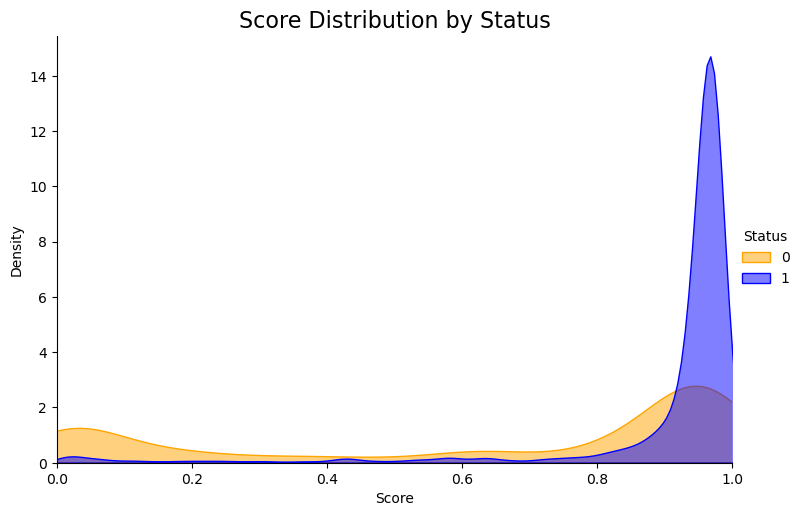

In [55]:
plot_density(df_test['pred_proba_rf_calibrated'], df_test['target'])


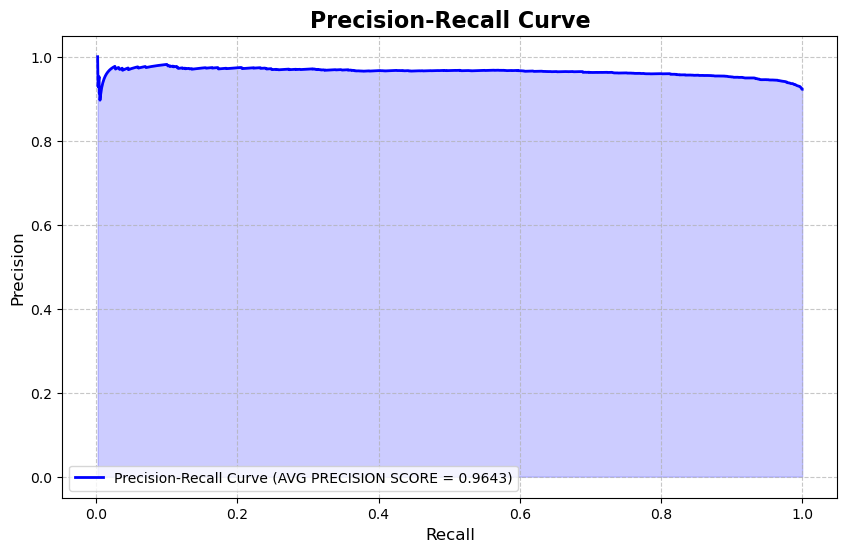

In [56]:
plot_precision_recall_curve(df_test['pred_proba_rf_calibrated'], df_test['target'])


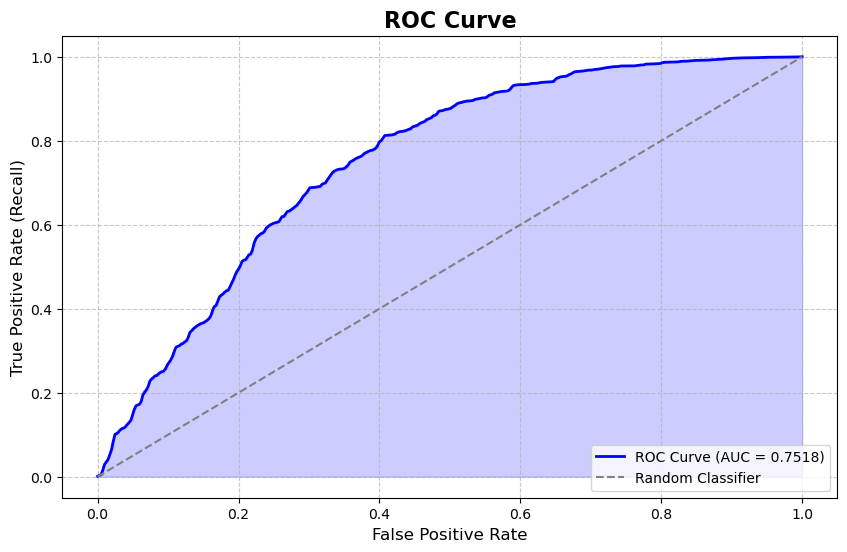

In [57]:
plot_roc_curve(df_test['pred_proba_rf_calibrated'], df_test['target'])


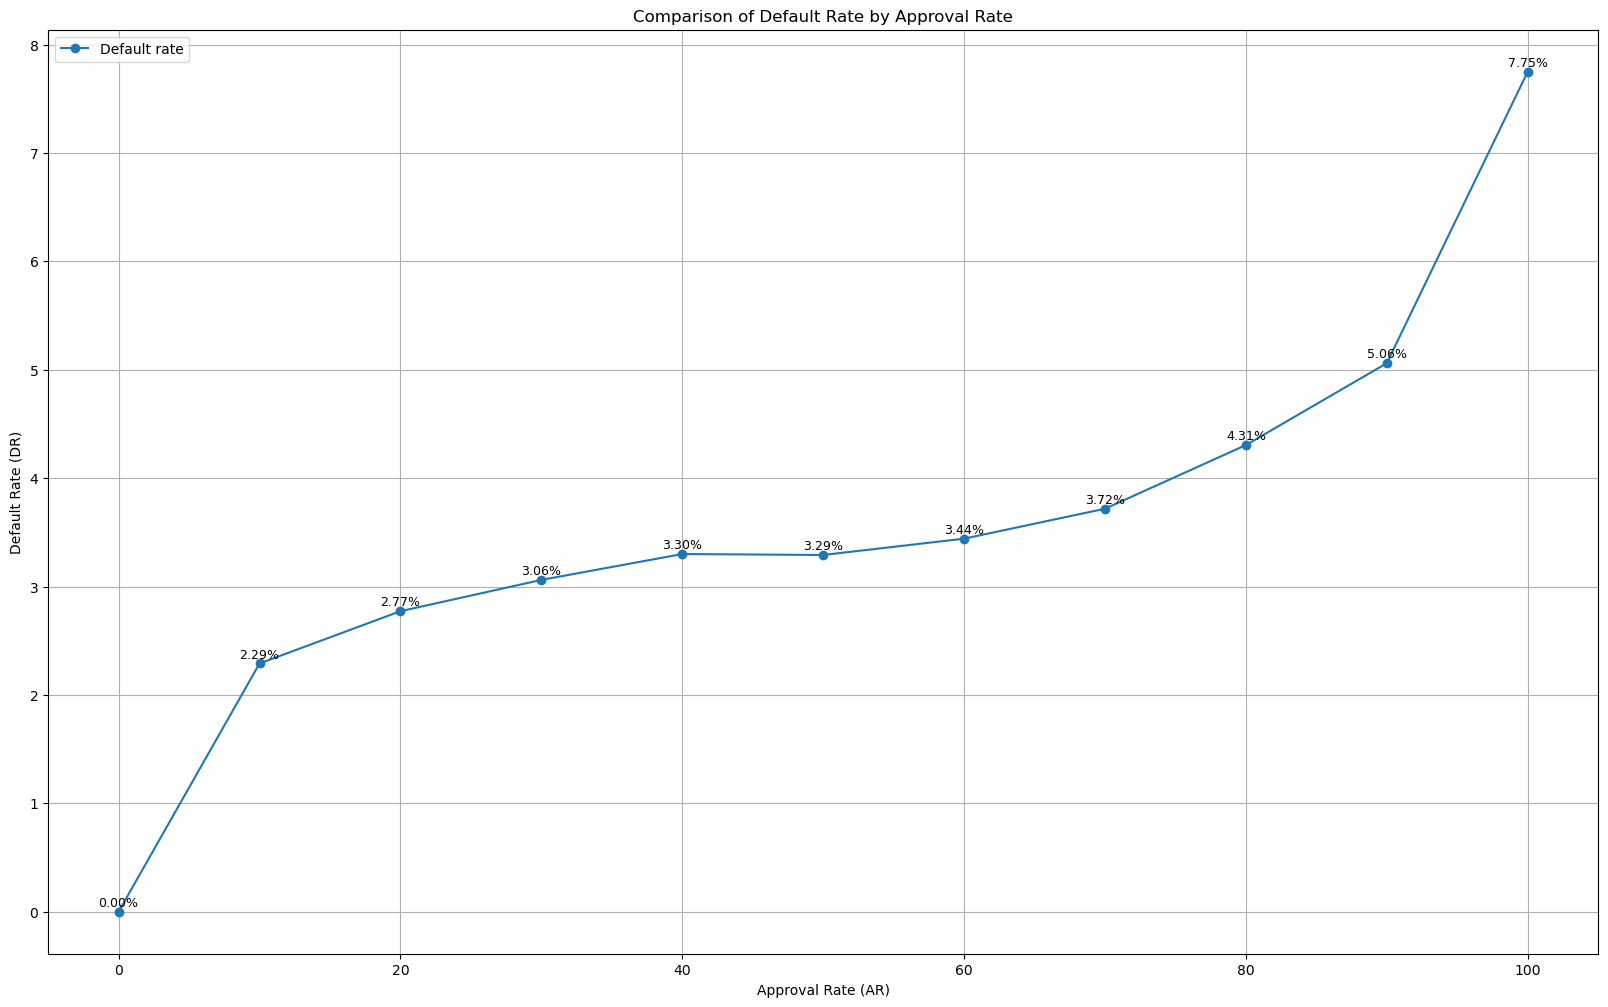

In [58]:
plot_ar_vs_dr(df_test['pred_proba_rf_calibrated'], df_test['target'])
